In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import warnings

df = pd.read_csv('dsci_filter_log_4sigma.csv')
# Drop identifier and ZIP code columns not used as features
df.drop(['parcelid', 'ZIP'], axis=1, inplace=True)
# One-hot encode categorical variables
df = pd.get_dummies(df, columns=['buildingqualitytypeid', 'propertylandusetypeid'], drop_first=True)

X = df.drop('taxvaluedollarcnt', axis=1)
y = df['taxvaluedollarcnt']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Train set size:", X_train.shape, "Test set size:", X_test.shape)

# Baseline MAE (mean predictor)
train_mean_value = y_train.mean()
baseline_pred_train = np.full(len(y_train), train_mean_value)
baseline_pred_test = np.full(len(y_test), train_mean_value)
baseline_mae_train = mean_absolute_error(y_train, baseline_pred_train)
baseline_mae_test = mean_absolute_error(y_test, baseline_pred_test)

# Evaluation metric function
def compute_metrics(y_true, y_pred, baseline_mae):
    mae_val = mean_absolute_error(y_true, y_pred)
    mse_val = mean_squared_error(y_true, y_pred)
    rmse_val = np.sqrt(mse_val)
    mask = y_true != 0
    mape_val = np.mean(np.abs((y_pred[mask] - y_true[mask]) / y_true[mask])) * 100
    y_pred_clip = np.where(y_pred < 0, 0, y_pred)
    y_true_clip = np.where(y_true < 0, 0, y_true)
    msle_val = mean_squared_error(np.log1p(y_true_clip), np.log1p(y_pred_clip))
    rmsle_val = np.sqrt(msle_val)
    r2_val = r2_score(y_true, y_pred)
    mase_val = mae_val / baseline_mae if baseline_mae != 0 else np.nan
    return r2_val, mae_val, rmse_val, mape_val, mase_val, rmsle_val

Train set size: (1373352, 39) Test set size: (343339, 39)


In [4]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
import numpy as np

kf = KFold(n_splits=5, shuffle=True, random_state=42)

cv_r2, cv_mae, cv_rmse, cv_mape, cv_mase, cv_rmsle = [], [], [], [], [], []

# 5-fold Cross Validation
for train_idx, val_idx in kf.split(X_train):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    model = LinearRegression()
    model.fit(X_tr, y_tr)
    y_val_pred = model.predict(X_val)
    r2, mae, rmse, mape, mase, rmsle = compute_metrics(y_val, y_val_pred, baseline_mae_train)
    cv_r2.append(r2)
    cv_mae.append(mae)
    cv_rmse.append(rmse)
    cv_mape.append(mape)
    cv_mase.append(mase)
    cv_rmsle.append(rmsle)

#results
cv_results = {
    "R2":    np.mean(cv_r2),
    "MAE":   np.mean(cv_mae),
    "RMSE":  np.mean(cv_rmse),
    "MAPE":  np.mean(cv_mape),
    "MASE":  np.mean(cv_mase),
    "RMSLE": np.mean(cv_rmsle)
}

lin_reg_final = LinearRegression()
lin_reg_final.fit(X_train, y_train)

y_test_pred = lin_reg_final.predict(X_test)
r2_te, mae_te, rmse_te, mape_te, mase_te, rmsle_te = compute_metrics(
    y_test, y_test_pred, baseline_mae_test
)

test_results = {
    "R2":    r2_te,
    "MAE":   mae_te,
    "RMSE":  rmse_te,
    "MAPE":  mape_te,
    "MASE":  mase_te,
    "RMSLE": rmsle_te
}

print("\n===== Linear Regression CV Results =====")
for k, v in cv_results.items():
    print(f"{k}: {v:.4f}")

print("\n===== Linear Regression Test Results =====")
for k, v in test_results.items():
    print(f"{k}: {v:.4f}")



===== Linear Regression CV Results =====
R2: 0.4959
MAE: 177889.6287
RMSE: 303090.6829
MAPE: 83.4390
MASE: 0.7346
RMSLE: 1.1298

===== Linear Regression Test Results =====
R2: 0.4981
MAE: 177992.3093
RMSE: 302886.0391
MAPE: 83.2003
MASE: 0.7328
RMSLE: 1.1311


In [5]:
#RF parameters
rf_reg = RandomForestRegressor(
    n_estimators=200,
    max_depth=25,
    min_samples_leaf=50,
    max_samples=0.5,
    max_features=8,
    n_jobs=-1,
    random_state=42
)

#5-fold cross validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

cv_r2 = []
cv_mae = []
cv_rmse = []
cv_mape = []
cv_mase = []
cv_rmsle = []

for tr_idx, val_idx in kf.split(X_train):
    X_tr, X_val = X_train.iloc[tr_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[tr_idx], y_train.iloc[val_idx]
    rf_reg.fit(X_tr, y_tr)
    y_val_pred = rf_reg.predict(X_val)
    r2, mae, rmse, mape, mase, rmsle = compute_metrics(y_val, y_val_pred, baseline_mae_train)
    cv_r2.append(r2)
    cv_mae.append(mae)
    cv_rmse.append(rmse)
    cv_mape.append(mape)
    cv_mase.append(mase)
    cv_rmsle.append(rmsle)

cv_results = {
    "R2":   np.mean(cv_r2),
    "MAE":  np.mean(cv_mae),
    "RMSE": np.mean(cv_rmse),
    "MAPE": np.mean(cv_mape),
    "MASE": np.mean(cv_mase),
    "RMSLE": np.mean(cv_rmsle)
}

rf_reg.fit(X_train, y_train)
y_test_pred = rf_reg.predict(X_test)

test_r2, test_mae, test_rmse, test_mape, test_mase, test_rmsle = compute_metrics(y_test, y_test_pred, baseline_mae_test)

test_results = {
    "R2":   test_r2,
    "MAE":  test_mae,
    "RMSE": test_rmse,
    "MAPE": test_mape,
    "MASE": test_mase,
    "RMSLE": test_rmsle
}

print("\n===== CV Results =====")
for k, v in cv_results.items():
    print(f"{k}: {v:.4f}")

print("\n===== Test Results =====")
for k, v in test_results.items():
    print(f"{k}: {v:.4f}")


===== CV Results =====
R2: 0.6022
MAE: 153540.9866
RMSE: 269234.3207
MAPE: 74.0123
MASE: 0.6341
RMSLE: 0.6479

===== Test Results =====
R2: 0.6063
MAE: 153187.4660
RMSE: 268258.1601
MAPE: 73.6206
MASE: 0.6307
RMSLE: 0.6460


In [6]:
#XGBoost parameters
xgb_reg = XGBRegressor(
    n_estimators=300,
    max_depth=7,
    learning_rate=0.10,
    min_child_weight=250,
    subsample=0.6,
    colsample_bytree=0.6,
    reg_lambda=10,
    reg_alpha=0.5,
    tree_method='hist',
    n_jobs=4,
    random_state=42
)

#5-fold cross validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

cv_r2, cv_mae, cv_rmse, cv_mape, cv_mase, cv_rmsle = [], [], [], [], [], []

for train_idx, val_idx in kf.split(X_train):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    xgb_reg.fit(X_tr, y_tr)
    y_val_pred = xgb_reg.predict(X_val)
    r2, mae, rmse, mape, mase, rmsle = compute_metrics(y_val, y_val_pred, baseline_mae_train)
    cv_r2.append(r2)
    cv_mae.append(mae)
    cv_rmse.append(rmse)
    cv_mape.append(mape)
    cv_mase.append(mase)
    cv_rmsle.append(rmsle)

cv_results = {
    "R2":    np.mean(cv_r2),
    "MAE":   np.mean(cv_mae),
    "RMSE":  np.mean(cv_rmse),
    "MAPE":  np.mean(cv_mape),
    "MASE":  np.mean(cv_mase),
    "RMSLE": np.mean(cv_rmsle)
}

xgb_reg.fit(X_train, y_train)

y_test_pred_xgb = xgb_reg.predict(X_test)
r2_te, mae_te, rmse_te, mape_te, mase_te, rmsle_te = compute_metrics(
    y_test, y_test_pred_xgb, baseline_mae_test
)

test_results = {
    "R2":    r2_te,
    "MAE":   mae_te,
    "RMSE":  rmse_te,
    "MAPE":  mape_te,
    "MASE":  mase_te,
    "RMSLE": rmsle_te
}

print("\n===== XGBoost CV Results =====")
for k, v in cv_results.items():
    print(f"{k}: {v:.4f}")

print("\n===== XGBoost Test Results =====")
for k, v in test_results.items():
    print(f"{k}: {v:.4f}")


===== XGBoost CV Results =====
R2: 0.6149
MAE: 152838.7605
RMSE: 264900.8654
MAPE: 73.4117
MASE: 0.6312
RMSLE: 0.6485

===== XGBoost Test Results =====
R2: 0.6185
MAE: 152776.3544
RMSE: 264075.3195
MAPE: 73.1781
MASE: 0.6290
RMSLE: 0.6481


In [7]:
#LightGBM parameters
lgbm_reg = LGBMRegressor(
    n_estimators=1200,
    learning_rate=0.02,
    num_leaves=60,
    lambda_l1=2.0,
    lambda_l2=10.0,
    min_child_samples=350,
    subsample=1,
    subsample_freq=1,
    colsample_bytree=0.6,
    metric='rmse',
    n_jobs=-1,
    random_state=42
)

#5-fold cross validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

cv_r2 = []
cv_mae = []
cv_rmse = []
cv_mape = []
cv_mase = []
cv_rmsle = []

for train_idx, val_idx in kf.split(X_train):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    lgbm_reg.fit(X_tr, y_tr)
    y_val_pred = lgbm_reg.predict(X_val)
    r2, mae, rmse, mape, mase, rmsle = compute_metrics(y_val, y_val_pred, baseline_mae_train)
    cv_r2.append(r2)
    cv_mae.append(mae)
    cv_rmse.append(rmse)
    cv_mape.append(mape)
    cv_mase.append(mase)
    cv_rmsle.append(rmsle)

cv_results = {
    "R2":    np.mean(cv_r2),
    "MAE":   np.mean(cv_mae),
    "RMSE":  np.mean(cv_rmse),
    "MAPE":  np.mean(cv_mape),
    "MASE":  np.mean(cv_mase),
    "RMSLE": np.mean(cv_rmsle)
}

lgbm_reg.fit(X_train, y_train)

y_test_pred = lgbm_reg.predict(X_test)

r2_te, mae_te, rmse_te, mape_te, mase_te, rmsle_te = compute_metrics(
    y_test, y_test_pred, baseline_mae_test
)

test_results = {
    "R2":    r2_te,
    "MAE":   mae_te,
    "RMSE":  rmse_te,
    "MAPE":  mape_te,
    "MASE":  mase_te,
    "RMSLE": rmsle_te
}

print("\n===== LightGBM CV Results =====")
for k, v in cv_results.items():
    print(f"{k}: {v:.4f}")

print("\n===== LightGBM Test Results =====")
for k, v in test_results.items():
    print(f"{k}: {v:.4f}")

[LightGBM] [Warning] lambda_l1 is set=2.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0
[LightGBM] [Warning] lambda_l2 is set=10.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.0
[LightGBM] [Warning] lambda_l1 is set=2.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0
[LightGBM] [Warning] lambda_l2 is set=10.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.0
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019847 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3140
[LightGBM] [Info] Number of data points in the train set: 1098681, number of used features: 28
[LightGBM] [Info] Start training from score 385717.968534
[LightGBM] [Warning] lambda_l1 is set=2.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0
[LightGBM] [Warning] lambda_l2 is set=10.0, reg_lambda=0.0 will be


===== Random Forest Feature Importance (sorted) =====
                        feature  importance
0          finishedsquarefeet12    0.305478
1                   bathroomcnt    0.142227
2    buildingqualitytypeid_10.0    0.089344
3     buildingqualitytypeid_7.0    0.060515
4                      latitude    0.051153
5                      SEA_DIST    0.046502
6                     longitude    0.043534
7     buildingqualitytypeid_4.0    0.040170
8                    POPULATION    0.024750
9                    bedroomcnt    0.023782
10                    yearbuilt    0.022318
11   buildingqualitytypeid_12.0    0.017988
12            lotsizesquarefeet    0.015577
13             Pollution_Burden    0.015236
14                        PM2_5    0.014949
15                        ratio    0.014845
16                         SQMI    0.013142
17               Drinking_Water    0.011919
18          Groundwater_Threats    0.011563
19                      Traffic    0.009502
20  propertylandusety

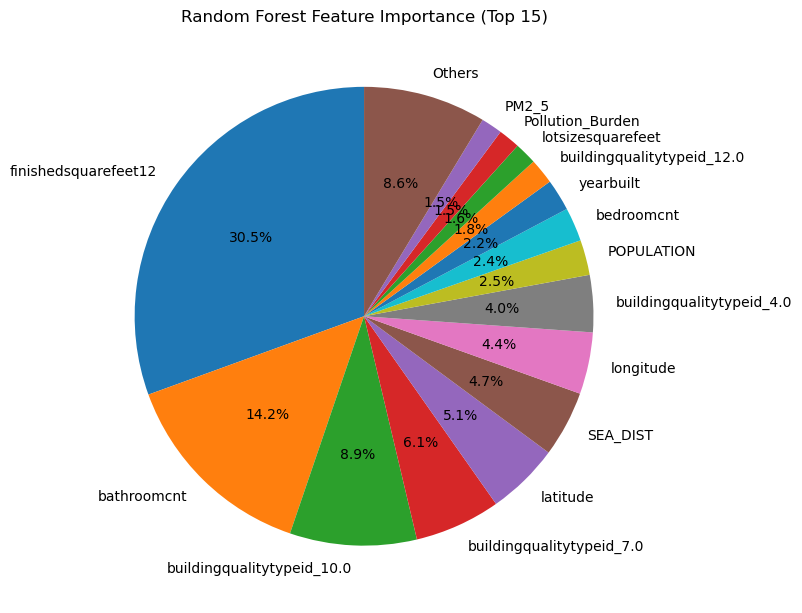


===== XGBoost Feature Importance (sorted) =====
                        feature  importance
0          finishedsquarefeet12    0.165067
1     buildingqualitytypeid_4.0    0.137637
2                   bathroomcnt    0.136037
3    buildingqualitytypeid_10.0    0.120345
4     buildingqualitytypeid_7.0    0.106679
5    buildingqualitytypeid_12.0    0.078512
6                    POPULATION    0.028494
7                      latitude    0.020727
8   propertylandusetypeid_261.0    0.018602
9                      SEA_DIST    0.018514
10  propertylandusetypeid_266.0    0.016815
11                    longitude    0.016654
12             Pollution_Burden    0.015743
13                        PM2_5    0.015034
14               Drinking_Water    0.013737
15                   Pesticides    0.013525
16                    yearbuilt    0.010658
17          Groundwater_Threats    0.010287
18            Imp__Water_Bodies    0.010022
19                  Solid_Waste    0.009574
20                      Tra

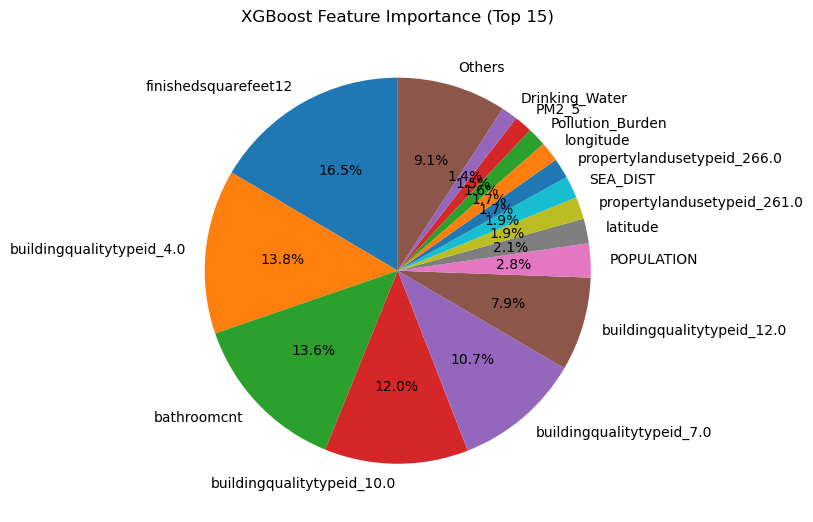


===== LightGBM Feature Importance (sorted) =====
                        feature  importance
0                      latitude        9063
1                     longitude        7827
2          finishedsquarefeet12        6839
3                     yearbuilt        6303
4             lotsizesquarefeet        5658
5                         ratio        4571
6                      SEA_DIST        3696
7                          SQMI        3237
8                    POPULATION        2700
9                   bathroomcnt        2619
10             Pollution_Burden        2316
11               Drinking_Water        2281
12                      Traffic        2201
13          Groundwater_Threats        1900
14                   bedroomcnt        1701
15                        PM2_5        1347
16                  Solid_Waste        1191
17            Imp__Water_Bodies        1147
18   buildingqualitytypeid_10.0         785
19    buildingqualitytypeid_4.0         707
20  propertylandusetypeid_

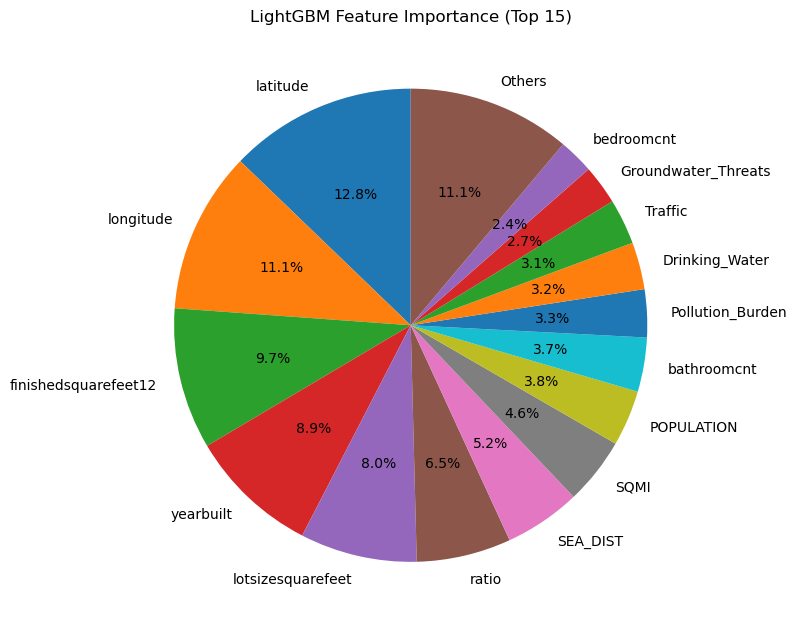

In [8]:
import matplotlib.pyplot as plt

feature_names = X_train.columns
def get_feature_importance_df(model, feature_names, model_name, top_n=10):
    importances = model.feature_importances_
    df_imp = pd.DataFrame({
        "feature": feature_names,
        "importance": importances
    }).sort_values("importance", ascending=False).reset_index(drop=True)

    print(f"\n===== {model_name} Feature Importance (sorted) =====")
    print(df_imp)

    top_df = df_imp.iloc[:top_n].copy()
    if len(df_imp) > top_n:
        others_sum = df_imp.iloc[top_n:]["importance"].sum()
        top_df.loc[len(top_df)] = ["Others", others_sum]

    plt.figure(figsize=(8, 8))
    plt.pie(
        top_df["importance"],
        labels=top_df["feature"],
        autopct="%1.1f%%",
        startangle=90
    )
    plt.title(f"{model_name} Feature Importance (Top {top_n})")
    plt.tight_layout()
    plt.show()

    return df_imp

# Random Forest feature importance
rf_importance_df = get_feature_importance_df(
    rf_reg, feature_names, model_name="Random Forest", top_n=15
)

# XGBoost feature importance
xgb_importance_df = get_feature_importance_df(
    xgb_reg, feature_names, model_name="XGBoost", top_n=15
)

# LightGBM feature importance
lgbm_importance_df = get_feature_importance_df(
    lgbm_reg, feature_names, model_name="LightGBM", top_n=15
)


In [9]:
#Hybrid (RF + XGB)
hybrid_train_pred = 0.5 * rf_reg.predict(X_train) + 0.5 * xgb_reg.predict(X_train)
hybrid_test_pred  = 0.5 * rf_reg.predict(X_test)  + 0.5 * xgb_reg.predict(X_test)

r2_tr, mae_tr, rmse_tr, mape_tr, mase_tr, rmsle_tr = compute_metrics(y_train, hybrid_train_pred, baseline_mae_train)
r2_te, mae_te, rmse_te, mape_te, mase_te, rmsle_te = compute_metrics(y_test, hybrid_test_pred, baseline_mae_test)

print("\n===== Hybrid (RF + XGB) Train Results =====")
print(f"R2: {r2_tr:.4f}")
print(f"MAE: {mae_tr:.4f}")
print(f"RMSE: {rmse_tr:.4f}")
print(f"MAPE: {mape_tr:.4f}")
print(f"MASE: {mase_tr:.4f}")
print(f"RMSLE: {rmsle_tr:.4f}")

print("\n===== Hybrid (RF + XGB) Test Results =====")
print(f"R2: {r2_te:.4f}")
print(f"MAE: {mae_te:.4f}")
print(f"RMSE: {rmse_te:.4f}")
print(f"MAPE: {mape_te:.4f}")
print(f"MASE: {mase_te:.4f}")
print(f"RMSLE: {rmsle_te:.4f}")


===== Hybrid (RF + XGB) Train Results =====
R2: 0.6297
MAE: 150410.0947
RMSE: 259758.6218
MAPE: 72.7644
MASE: 0.6212
RMSLE: 0.6414

===== Hybrid (RF + XGB) Test Results =====
R2: 0.6166
MAE: 152399.6719
RMSE: 264726.7645
MAPE: 73.2753
MASE: 0.6275
RMSLE: 0.6446


In [10]:
from sklearn.ensemble import StackingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

rf_reg = RandomForestRegressor(
    n_estimators=200,
    max_depth=25,
    min_samples_leaf=50,
    max_samples=0.5,
    max_features=8,
    n_jobs=-1,
    random_state=42
)

xgb_reg = XGBRegressor(
    n_estimators=300,
    max_depth=7,
    learning_rate=0.10,
    min_child_weight=250,
    subsample=0.6,
    colsample_bytree=0.6,
    reg_lambda=10,
    reg_alpha=0.5,
    tree_method='hist',
    n_jobs=4,
    random_state=42
)

lgbm_reg = LGBMRegressor(
    n_estimators=1200,
    learning_rate=0.02,
    num_leaves=60,
    lambda_l1=2.0,
    lambda_l2=10.0,
    min_child_samples=350,
    subsample=1,
    subsample_freq=1,
    colsample_bytree=0.6,
    metric='rmse',
    n_jobs=-1,
    random_state=42
)

#Do stacking based on RF,XGB and LGBM
base_estimators = [
    ('rf', rf_reg),
    ('xgb', xgb_reg),
    ('lgbm', lgbm_reg),
]

stack_reg = StackingRegressor(
    estimators=base_estimators,
    final_estimator=LinearRegression(),
    cv=5,
    n_jobs=-1
)

stack_reg.fit(X_train, y_train)

y_train_pred_stack = stack_reg.predict(X_train)
y_test_pred_stack = stack_reg.predict(X_test)

r2_tr, mae_tr, rmse_tr, mape_tr, mase_tr, rmsle_tr = compute_metrics(y_train, y_train_pred_stack, baseline_mae_train)
r2_te, mae_te, rmse_te, mape_te, mase_te, rmsle_te = compute_metrics(y_test, y_test_pred_stack, baseline_mae_test)

print("Stacked Ensemble Metrics (tuned base models):")
print(f"Train -> R^2: {r2_tr:.4f}, MAE: {mae_tr:.2f}, RMSE: {rmse_tr:.2f}, "
      f"MAPE: {mape_tr:.2f}%, MASE: {mase_tr:.3f}, RMSLE: {rmsle_tr:.4f}")
print(f"Test  -> R^2: {r2_te:.4f}, MAE: {mae_te:.2f}, RMSE: {rmse_te:.2f}, "
      f"MAPE: {mape_te:.2f}%, MASE: {mase_te:.3f}, RMSLE: {rmsle_te:.4f}")

[LightGBM] [Warning] lambda_l1 is set=2.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0
[LightGBM] [Warning] lambda_l2 is set=10.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.0
[LightGBM] [Warning] lambda_l1 is set=2.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0
[LightGBM] [Warning] lambda_l2 is set=10.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.0
Stacked Ensemble Metrics (tuned base models):
Train -> R^2: 0.6369, MAE: 150599.33, RMSE: 257219.07, MAPE: 72.80%, MASE: 0.622, RMSLE: 0.6436
Test  -> R^2: 0.6223, MAE: 152184.31, RMSE: 262757.54, MAPE: 72.93%, MASE: 0.627, RMSLE: 0.6441
